# import necessary modules and data

In [7]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from rbm import RBM, localRBM
from mcmc import *

In [2]:
# import MNIST data set and make them binary
(x_train, y_train), (x_test, y_test) = mnist.load_data()
def transform_input(x_t):
    x_t = np.sign(x_t-np.full(x_t.shape,15))
    x_t = x_t+np.ones(x_t.shape)
    return x_t/2
x_train = transform_input(x_train)
x_test = transform_input(x_test)

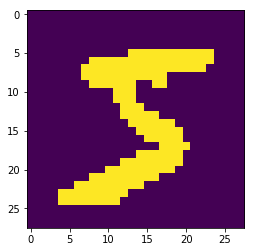

In [5]:
# one of the MNIST sample
plt.imshow(x_train[0])
plt.show()

# compile and train an RBM

In [10]:
m= RBM([28,28],[20,20])

In [11]:
m.fit(x_train, x_test[:2000], batch=10, epoch=3, cdkstep=1, learningrate=0.005) 

-------------------
epoch: 1 finished
the reconstruction error: 0.0719591836735
the free energy difference between training and evaluation set: -1.62665958047
the free energy difference between training and standard set: -490.45376387
the magnitude of weights and the updates:
19217.2031925 299.460975716
-------------------
epoch: 2 finished
the reconstruction error: 0.0575503826531
the free energy difference between training and evaluation set: -0.944276228235
the free energy difference between training and standard set: -562.35853073
the magnitude of weights and the updates:
24334.1629378 266.095423296
-------------------
epoch: 3 finished
the reconstruction error: 0.0505880102041
the free energy difference between training and evaluation set: -0.904619577578
the free energy difference between training and standard set: -614.53392259
the magnitude of weights and the updates:
27787.5611507 258.052548817


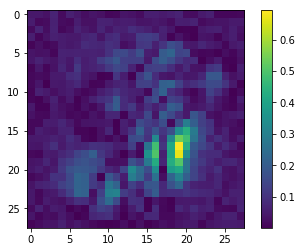

In [13]:
# the weights have some locality features
plt.imshow(np.abs(m.getweights()[0][13]))
plt.colorbar()
plt.show()

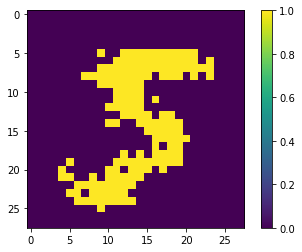

In [14]:
# recover of the image
plt.imshow(m.Gibbsupdate(x_train[0:1],nosteps=1)[0].reshape(28,28))
plt.colorbar()
plt.show()

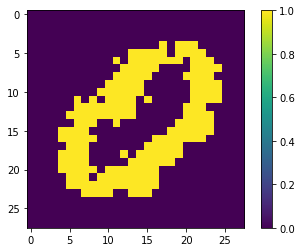

In [15]:
# generate new image after long gibbs updates
plt.imshow(m.Gibbsupdate(x_train[0:1],nosteps=1000)[0].reshape(28,28))
plt.colorbar()
plt.show()

# classical Monte Carlo method

In [16]:
ising = Ising([10,10],coupling=[0.,0., -1.])

In [19]:
mc = mcmeasure(ising,[mag()]) 
mc.mcmove(1/2.2,50000,method='local_update')

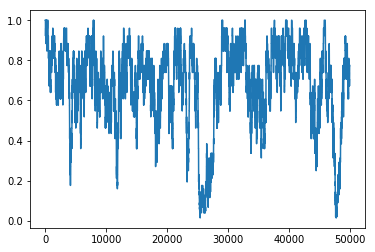

In [22]:
# the m^2 value on the Markov chain
plt.plot(list(map(lambda x:x**2, np.array(mc.values)[:,0])))
plt.show()

In [23]:
analysis(np.array(mc.values)[10000:,0],2)

the expectation value, standard deviation and autocorrelation time are correspondingly:


[0.66547943301417445, 0.034927465235743853, 505.38415213825022]

# train an RBM as the MC update proposal
* Use MCMC generate samples
* Train the RBM using these samples
* Generate new samples from the RBM
* Compare the expectation value of physical observables 

*Note the difference where MCMC is written in $\pm 1$ configs while RBM is implemented in 1,0 binary variables *

In [24]:
ising = Ising([10,10],coupling=[0., 0, -1])
mc = writeconf2file(ising,2000,4,'spinsample.npy') 
# note to delete the npy file first if you want to generate configs by yourself with the same file name
mc.mcmove(1/2.3,2000+4*20000,method='wolff_update')

In [25]:
spin = mc.readconf()
spin = spin2binary(spin)
spin.shape

(20000, 10, 10)

In [26]:
m = RBM([10,10],[20,20])

In [31]:
# the training before is omited, you may need around 100 epochs in total to train this model well
m.fit(spin[:19000], spin[19001:], batch=10, epoch=5, cdkstep=5, learningrate=0.0008) 

-------------------
epoch: 1 finished
the reconstruction error: 0.115525525526
the free energy difference between training and evaluation set: -0.461463871122
the free energy difference between training and standard set: -61.3235508474
the magnitude of weights and the updates:
5597.29039647 11.7993805616
-------------------
epoch: 2 finished
the reconstruction error: 0.113423423423
the free energy difference between training and evaluation set: -0.466468800827
the free energy difference between training and standard set: -61.3674374225
the magnitude of weights and the updates:
5638.24740519 12.9090008493
-------------------
epoch: 3 finished
the reconstruction error: 0.113453453453
the free energy difference between training and evaluation set: -0.47894857244
the free energy difference between training and standard set: -61.5360559363
the magnitude of weights and the updates:
5678.71829988 15.0250589387
-------------------
epoch: 4 finished
the reconstruction error: 0.112392392392
the 

In [28]:
bising = Ising([10,10], coupling = [8,0,-4]) # effective Hamiltonian for the binary data as Ising model

In [29]:
(np.mean([bising.energy2d(spin[i]) for i in range(20000)])\
-np.mean([bising.energy2d(np.random.randint(2, size=(10,10))) for i in range(20000)]))

-143.8048

In [32]:
np.mean([m.freeenergy(spin[i]) for i in range(20000)])\
-np.mean([m.freeenergy(np.random.randint(2, size=(10,10))) for _ in range(20000)])

-61.161111608582189

due to the probability ratio relation, we have $T\Delta F =\Delta E$, which gives us an estimate on temperature of these configuration samples as $143.8/61.16 \approx 2.35$, which is very close to the real temperature. And note all these results come from no prior physics knowledge!

In [33]:
mc = mcmeasure(ising,[mag()]) 
mc.mcmove(0,20000,method='rbm_update',tool=[m,5,False])
mc.mcmove(1/2.3,20000,method='wolff_update')
mc.mcmove(1/2.3,100000,method='local_update')

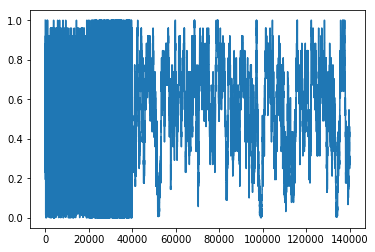

In [34]:
plt.plot(list(map(lambda x:x**2, np.array(mc.values)[:,0])))
plt.show()# show results from RBM update, wolff update and local update at the same time

In [35]:
analysis(np.array(mc.values)[2000:20000,0],2)

the expectation value, standard deviation and autocorrelation time are correspondingly:


[0.52380006666666667, 0.0038988547219810411, 2.9430200599235188]

In [36]:
analysis(np.array(mc.values)[22000:40000,0],2)

the expectation value, standard deviation and autocorrelation time are correspondingly:


[0.57948762222222283, 0.0049496475415616806, 2.9166238123484982]

In [37]:
analysis(np.array(mc.values)[45000:,0],2)

the expectation value, standard deviation and autocorrelation time are correspondingly:


[0.57266092777970889, 0.025335406588496638, 577.90640579009028]

The results is a little lower for RBM case which matches the result it gives a higher estimation on the temperature! 